# AutoML using Ludwig
## MIT-Chile Workshop
###### by Cristobal Donoso

In [4]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import logging
import shutil
import yaml
import os 

from ludwig.api import LudwigModel
from ludwig.datasets import mnist

The first step is to explore our data. In this we will use the [**Weather Image Recognition** dataset](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset) which contains 6862 images of different types of weather. 

,image_path,labels
484,./data/weather/raw/images/484.jpg,sandstorm
5928,./data/weather/raw/images/5928.jpg,fogsmog


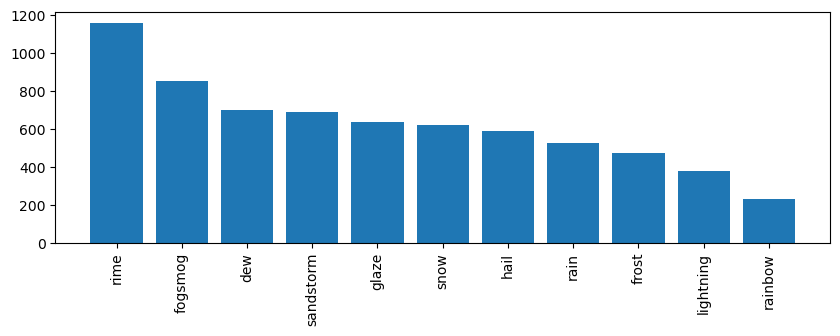

In [5]:
metadata = pd.read_csv('./data/weather/raw/raw_meta.csv')

x = metadata['labels'].value_counts().reset_index()['index']
y = metadata['labels'].value_counts().reset_index()['labels']
plt.figure(figsize=(10,3))
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x, rotation=90)

metadata.sample(2)

Lets look at one sample

In [44]:
sample = metadata.sample(6)
sample_path  = sample['image_path'].values
sample_label = sample['labels'].values

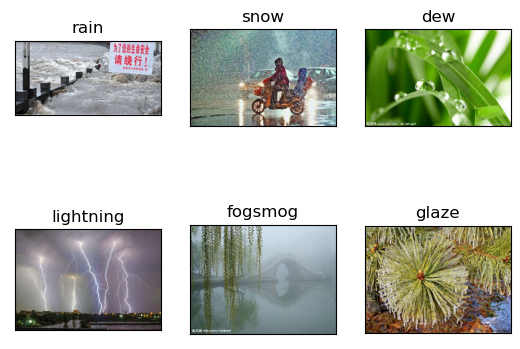

In [45]:
fig, axes = plt.subplots(2, 3, dpi=100)

for index, ax in enumerate(axes.flatten()):
    im = plt.imread(sample_path[index])
    ax.imshow(im)
    ax.set_title(sample_label[index])
    ax.set_xticks([])
    ax.set_yticks([])

In [46]:
# clean out prior results
shutil.rmtree("./results", ignore_errors=True)

### Preparing config file 

[Ludwig official documentation](https://ludwig.ai/latest/configuration/) provides a lot of attributes we can include in our config file. It ranges from preprocessing tools, features, hyperparameter optimization, and more.

In this tutorial we already have a configuration file which fits our input data

In [8]:
# set up Python dictionary to hold model training parameters
with open("./config.yaml") as f:
    config = yaml.safe_load(f.read())

In [9]:
config

{'input_features': [{'name': 'image_path',
   'type': 'image',
   'preprocessing': {'num_processes': 4,
    'split': {'type': 'random', 'probabilities': [0.7, 0.2, 0.1]}},
   'encoder': 'stacked_cnn',
   'conv_layers': [{'num_filters': 32,
     'filter_size': 3,
     'pool_size': 2,
     'pool_stride': 2},
    {'num_filters': 64,
     'filter_size': 3,
     'pool_size': 2,
     'pool_stride': 2,
     'dropout': 0.4}],
   'fc_layers': [{'output_size': 128, 'dropout': 0.4}]}],
 'output_features': [{'name': 'labels', 'type': 'category'}],
 'trainer': {'epochs': 5}}

## Using Ludwig Model 

As we have seen in the slides, Ludwig has command line options for training, predicting and visualizing. However, we can also use the [Ludwig model object `LudwigModel()`](https://ludwig.ai/latest/user_guide/api/LudwigModel/) that drive model training.




In [64]:
model = LudwigModel(config, logging_level=logging.INFO)

By using the method [`.train()`](https://ludwig.ai/latest/user_guide/api/LudwigModel/#train) we can start training using the loaded configuration 

In [65]:
# initiate model training
(train_stats, _, output_directory) = model.train(
    dataset=metadata,
    experiment_name="workshop_tutorial",
    model_name="weather_clf",
    skip_save_processed_input=True,
)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ workshop_tutorial                                                                                 │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ weather_clf                                                                                       │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /home/cridonoso/Documents/automl_tutorial/results/workshop_tutorial_weather_clf_1                 │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.6.4'                                          


╒═══════════════╕
│ PREPROCESSING │
╘═══════════════╛

Using in_memory = False is not supported with dataframe data format.
Using full dataframe
Building dataset (it may take a while)
Inferring num_channels from the first 100 images.
  images with 3 channels: 100
Using 3 channels because it is the majority in sample. If an image with a different depth is read, will attempt to convert to 3 channels.
To explicitly set the number of channels, define num_channels in the preprocessing dictionary of the image input feature config.


/home/cridonoso/miniconda3/envs/h2o/lib/python3.8/site-packages/ludwig/utils/image_utils.py:138: UserWarning: Failed to read image from PNG file. Original exception: Existing exports of data: object cannot be re-sized
  warnings.warn(f"Failed to read image from PNG file. Original exception: {e}")
/home/cridonoso/miniconda3/envs/h2o/lib/python3.8/site-packages/ludwig/utils/image_utils.py:149: UserWarning: Failed to read image from numpy file. Original exception: Cannot load file containing pickled data when allow_pickle=False
  warnings.warn(f"Failed to read image from numpy file. Original exception: {e}")
/home/cridonoso/miniconda3/envs/h2o/lib/python3.8/site-packages/ludwig/utils/image_utils.py:120: UserWarning: Unable to read image from bytes object.
  warnings.warn("Unable to read image from bytes object.")
/home/cridonoso/miniconda3/envs/h2o/lib/python3.8/site-packages/ludwig/features/image_feature.py:183: UserWarning: Image with value None cannot be read
  warnings.warn(f"Image wi

Failed to read 9 images while preprocessing feature `image_path`. Using default image for these rows in the dataset.
Building dataset: DONE

Dataset Statistics
╒════════════╤═══════════════╤════════════════════╕
│ Dataset    │   Size (Rows) │ Size (In Memory)   │
╞════════════╪═══════════════╪════════════════════╡
│ Training   │          4803 │ 717.76 Kb          │
├────────────┼───────────────┼────────────────────┤
│ Validation │           686 │ 102.62 Kb          │
├────────────┼───────────────┼────────────────────┤
│ Test       │          1373 │ 205.27 Kb          │
╘════════════╧═══════════════╧════════════════════╛

╒═══════╕
│ MODEL │
╘═══════╛

Warnings and other logs:

╒══════════╕
│ TRAINING │
╘══════════╛

Training for 190 step(s), approximately 5 epoch(s).
Early stopping policy: 5 round(s) of evaluation, or 190 step(s), approximately 5 epoch(s).

Starting with step 0, epoch: 0
Training:  20%|████████████████████████████                                                        

╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.9313 │
├────────────┼────────┤
│ validation │ 1.1535 │
├────────────┼────────┤
│ test       │ 1.1438 │
╘════════════╧════════╛
Validation loss on combined improved, model saved.

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [20:13<00:00,  6.39s/it]

╒═════════════════╕
│ TRAINING REPORT │
╘═════════════════╛

╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ combined           │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 190                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 5                  │
├──────────────────────────────┼─────────────────

## Visualizing results

In [71]:
import json 
import ludwig

file_object = './results/workshop_tutorial_weather_clf_1/training_statistics.json'
with open(file_object, 'rb') as file:
    training_stats = json.load(file)

In [74]:
from ludwig.visualize import learning_curves

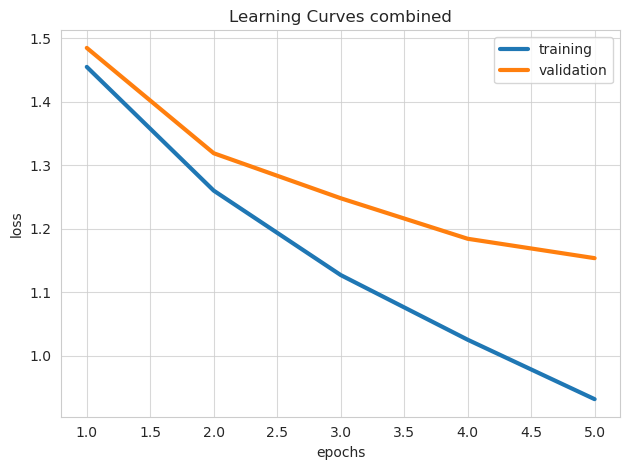

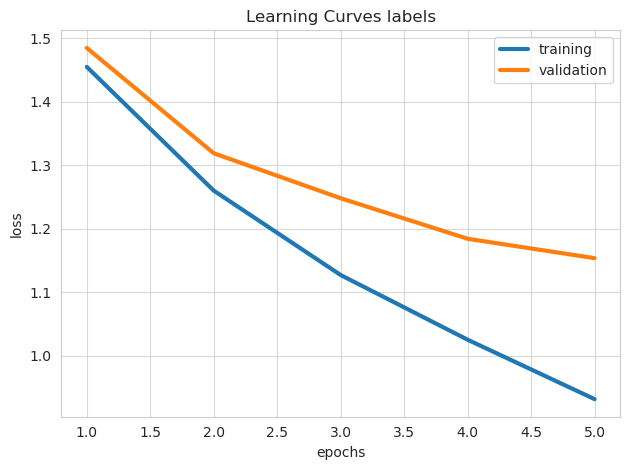

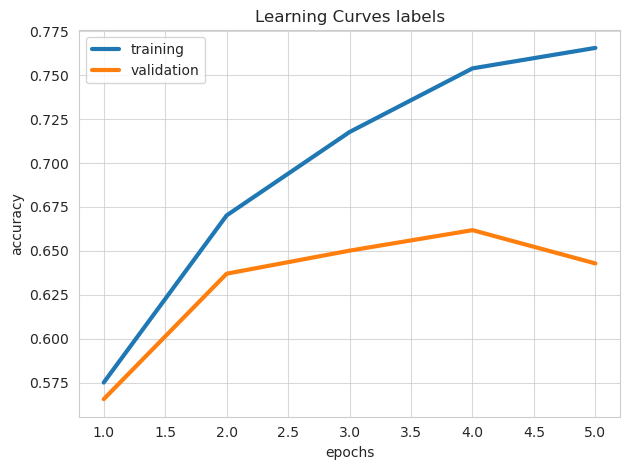

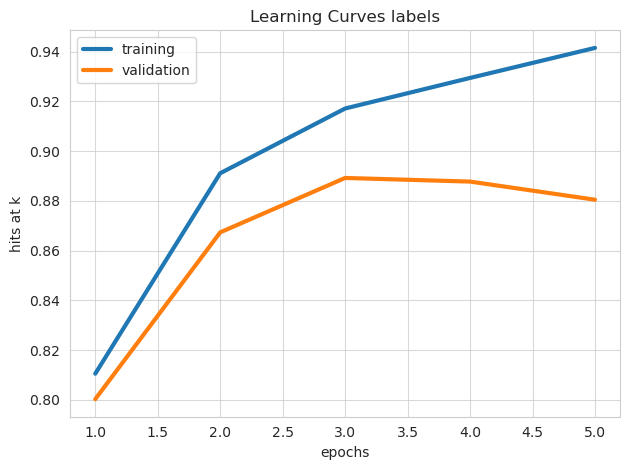

In [76]:
learning_curves(training_stats)

In [6]:
# test_ds
from ludwig.visualize import confusion_matrix_cli

In [11]:
model = LudwigModel(config, logging_level=logging.INFO)
model = model.load('./results/workshop_tutorial_weather_clf_1/model/')

In [12]:
subsample = metadata.sample(10)
res_frame, _ = model.predict(subsample, 
                             skip_save_predictions=False, 
                             output_directory='./results/workshop_tutorial_weather_clf_1/label_prediction')

In [15]:
res_frame

,labels_predictions,labels_probabilities,labels_probability,labels_probabilities_rime,labels_probabilities_fogsmog,labels_probabilities_dew,labels_probabilities_sandstorm,labels_probabilities_glaze,labels_probabilities_snow,labels_probabilities_hail,labels_probabilities_rain,labels_probabilities_frost,labels_probabilities_lightning,labels_probabilities_rainbow
0,lightning,"[0.017117958515882492, 0.0006644733948633075, ...",0.944892,0.017118,0.000664,0.023231,0.000759,0.000718,0.000595,0.000979,0.003941,0.002895,0.944892,0.004208
1,frost,"[0.015422941185534, 0.0004624249995686114, 0.1...",0.472097,0.015423,0.000462,0.176838,0.002202,0.214099,0.002827,0.055360,0.039158,0.472097,0.018707,0.002826
2,fogsmog,"[0.05108453333377838, 0.6389118432998657, 0.00...",0.638912,0.051085,0.638912,0.007613,0.168417,0.007526,0.013006,0.011169,0.019146,0.007189,0.013461,0.062475
3,rime,"[0.8966985940933228, 0.005283266305923462, 0.0...",0.896699,0.896699,0.005283,0.003779,0.004321,0.004029,0.059319,0.001566,0.009965,0.001171,0.000642,0.013226
4,rainbow,"[0.018476776778697968, 0.006069805473089218, 0...",0.852045,0.018477,0.006070,0.031414,0.008499,0.005804,0.009910,0.006811,0.013899,0.017976,0.029094,0.852045
5,sandstorm,"[0.020871425047516823, 0.10078106820583344, 0....",0.405245,0.020871,0.100781,0.046741,0.405245,0.038240,0.018809,0.095820,0.033606,0.051279,0.013240,0.175368
6,hail,"[0.08784277737140656, 0.02066980116069317, 0.1...",0.187031,0.087843,0.020670,0.114190,0.016460,0.060857,0.125076,0.187031,0.178371,0.111754,0.062549,0.035200
7,dew,"[0.04344915598630905, 0.0030313320457935333, 0...",0.345707,0.043449,0.003031,0.345707,0.008919,0.227111,0.009871,0.036680,0.041167,0.252896,0.012317,0.018851
8,fogsmog,"[0.17986395955085754, 0.2941713035106659, 0.03...",0.294171,0.179864,0.294171,0.036917,0.065045,0.036434,0.043687,0.032372,0.034778,0.047719,0.083408,0.145603
9,glaze,"[0.05679001286625862, 0.00320513010956347, 0.0...",0.319361,0.056790,0.003205,0.097068,0.006432,0.319361,0.032735,0.060604,0.280181,0.100393,0.034561,0.008670
